In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"
os.environ["NCCL_P2P_DISABLE"] = "3"
os.environ["NCCL_IB_DISABLE"] = "3"
import torch
from datasets import Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, peft_model, PeftModel
from trl import SFTTrainer
import copy
import numpy as np
import uuid
from tqdm.auto import tqdm
from tqdm import tqdm
import io
import json
import ast
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import pandas as pd
logging.set_verbosity(logging.CRITICAL)

### Config
TRAIN_SQUAD_PATH = '../data/squad/train-v1.1_classified_qtype_prob.jsonl'
TRAIN_CNN_PATH = '../data/cnn/cnn_train_classified.json'
TRAIN_HOTPOT_PATH = '../data/hotpot/hotpot_train_classified.jsonl'

load_dotenv()
question_type_str = os.getenv("QUESTION_TYPE")
question_type = ast.literal_eval(question_type_str)
question_type_list = list(question_type.values()) 

save_model_path = "../model/gen_question/ft_genqa_1110_2040/"
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
model_dict = {'0': 'TinyLlama/TinyLlama-1.1B-Chat-v1.0',
              '1': 'microsoft/Phi-3-mini-4k-instruct',
              '2': 'meta-llama/Meta-Llama-3.1-8B-Instruct',}
model_name = model_dict['1']  

In [ ]:
# 4bit 양자화 설정 
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)
# 모델 로드
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    use_cache=False # 학습 중에는 False로 설정
)
model.config.pretraining_tp = 1

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token # 패딩 토큰 설정
tokenizer.padding_side = "right" # fp16 학습 시 right padding 권장

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=32,                    # Rank 크기 (클수록 파라미터 많이 학습하지만 메모리 증가)
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"] # 튜닝할 모듈 지정
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.44s/it]


In [5]:
def open_squad(path):
    data = []
    with io.open(path, 'r', encoding='utf-8') as f:
        for example in f:
            data.append(json.loads(example))
    data = data[:1000] # debug size
    return data

def open_jsonl(path):
    data = []
    with io.open(path, 'r', encoding='utf-8') as f:
        for example in f:
            data.append(json.loads(example))
    # data = data[:5] # debug size
    return data

def open_json(path):
    with io.open(path, 'r', encoding='utf-8') as f:
        input_data = json.load(f)["data"]
    # input_data = input_data[:5]  # debug size
    return input_data

def parse_custom_data(raw_data):
    formatted_data = []
    for article in raw_data:
        for paragraph in article['paragraphs']:
            context = paragraph['context']
            for qa in paragraph['qas']:
                # 우리가 필요한 건 context, q_type -> question 입니다.
                formatted_data.append({
                    'context': context.strip(),
                    'q_type': qa['q_type'],
                    'question': qa['question'].strip()
                })
    return formatted_data

train_squad_data = open_squad(TRAIN_SQUAD_PATH)
train_cnn_data = open_json(TRAIN_CNN_PATH)
train_hotpot_data = open_jsonl(TRAIN_HOTPOT_PATH)

flat_data = parse_custom_data(train_squad_data)
train_dataset = Dataset.from_list(flat_data)
print(f"Number of training samples: {len(train_dataset)}")

Number of training samples: 87599


### Train

In [ ]:
def format_prompt(sample):
    return f"""### Instruction:
    Generate a question based on the provided Context and Question Type.

    **Rules:**
    1.  The question must be a **single sentence**.
    2.  The question must match the intent of the **Question Type code**:
        * 0: Abbreviation
        * 1: Description
        * 2: Entity
        * 3: Human
        * 4: Location
        * 5: Numeric
        
    ### Example:
    - Context: "The Eiffel Tower is in Paris"
    - Question Type: 4
    - Generated Question: "Where is the Eiffel Tower located?"    

    ### Input:
    Context: {sample['context']}
    Question Type: {sample['q_type']}

    ### Response:
    {sample['question']}"""

training_arguments = TrainingArguments(
    output_dir="../model/gen_question/checkpoint",
    num_train_epochs=3,           # 에포크 수 (데이터가 적으면 늘리세요)
    per_device_train_batch_size=2, # 배치 사이즈 (GPU 메모리에 맞춰 조절)
    gradient_accumulation_steps=4,
    optim="paged_adamw_32bit",
    save_steps=5000,
    logging_steps=10,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,                     # T4 GPU에서는 fp16 또는 bf16 사용
    bf16=False,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="none"               # wandb 등 리포팅 끄기
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    peft_config=peft_config,
    args=training_arguments,
    formatting_func=format_prompt, # 위에서 정의한 포맷팅 함수 적용
)

# 모델 학습
trainer.train()
# 학습된 모델 저장
trainer.model.save_pretrained(save_model_path)
tokenizer.save_pretrained(save_model_path)

### Validation

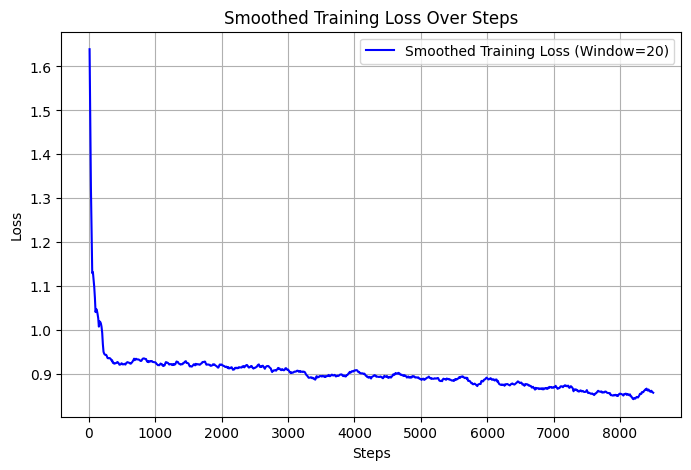

In [34]:
# 학습 기록(log history)
log_history = trainer.state.log_history
df = pd.DataFrame(log_history)
plt.figure(figsize=(8, 5))

train_loss = df[df['loss'].notna()].copy()
window_size = 20 

train_loss['loss_smoothed'] = train_loss['loss'].rolling(window=window_size, min_periods=1).mean()

plt.plot(train_loss['step'], train_loss['loss_smoothed'], 
         label=f"Smoothed Training Loss (Window={window_size})", 
         color='blue') 
# x축 눈금 설정
max_step = train_loss['step'].max()
x_ticks = np.arange(0, max_step + 1, 1000)
plt.xticks(x_ticks)

plt.title("Smoothed Training Loss Over Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Inference

In [23]:
model_name = 'microsoft/Phi-3-mini-4k-instruct'
trained_model_path = '../model/gen_question/ft_genqa_1110_2040/'
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    use_cache=False # 학습 중에는 False로 설정
)
base_model.config.pretraining_tp = 1
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token # 패딩 토큰 설정
tokenizer.padding_side = "right" # fp16 학습 시 right padding 권장
# PEFT로 미세조정된 모델 로드
trained_model = PeftModel.from_pretrained(base_model, trained_model_path)
trained_model = trained_model.merge_and_unload()
trained_model.eval()
pipe = pipeline(task="text-generation", model=trained_model,tokenizer=tokenizer, max_new_tokens=64) 

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.14s/it]
/home/gayeon39/miniconda3/envs/da/lib/python3.12/site-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
Device set to use cuda:0


In [ ]:
QUESTION_TYPE_MAP = {
    0: 'ABBR (Abbreviation)', 1: 'DESC (Description)', 2: 'ENTY (Entity)',
    3: 'HUM (Human)', 4: 'LOC (Location)', 5: 'NUM (Number)'
}
def create_detailed_prompt(context, q_type):
    q_type_str = QUESTION_TYPE_MAP.get(q_type, str(q_type))
    prompt = f"""### Instruction:
    Generate a high-quality question based on the following context and question type.

    **Constraints:**
    1.  The question **must** be a single, complete sentence.
    2.  The question **must** be directly answerable using **only** the information provided in the Context.
    3.  The question **must** match the specified "Question Type".

    **Question Type Definitions:**
    - 0 (ABBR): Asks for the meaning of an abbreviation. (약어)
    - 1 (DESC): Asks for a description of something. (설명)
    - 2 (ENTY): Asks about an entity (e.g., thing, organization). (개체)
    - 3 (HUM): Asks about a person or group of people. (인물)
    - 4 (LOC): Asks about a location. (장소)
    - 5 (NUM): Asks about a number, date, or quantity. (숫자, 수량)

    ### Input:
    Context: {context}
    Question Type: {q_type_str}

    ### Response:
    """
    return prompt


test_context = "The International Space Station (ISS) is a modular space station in low Earth orbit. It is a multinational collaborative project involving five participating space agencies: NASA (United States), Roscosmos (Russia), JAXA (Japan), ESA (Europe), and CSA (Canada)."
test_q_type = 4 # 4: LOC (Location)
prompt = create_detailed_prompt(test_context, test_q_type)

print("\n--- 추론 시작 ---")
result = pipe(prompt)
print(result[0]['generated_text'])
# '### Response:' 뒷부분만 깔끔하게 추출
answer = result[0]['generated_text'].split("### Response:")[-1].strip()
print(answer)

In [ ]:
def generate_question_cnn(data, output_path, question_type_li, pipe):
    gen_data = []
    for idx1, original_data in enumerate(tqdm(data, desc="Generating questions")): 
        title = original_data['title']
        modified_paragraph = copy.deepcopy(original_data['paragraphs'][0])
        context = modified_paragraph['context']
        original_qas_list = modified_paragraph['qas']
        
        final_qas_list = []
        
        for q in original_qas_list:
            final_qas_list.append({
                'id': q['id'],
                'q_type': q['q_type'],
                'question': q['question']
            })

        for q_type in question_type_li: 
            prompt = f"""### Instruction:
                Generate a question based on the following context and question type.

                ### Input:
                Context: {context}
                Question Type: {q_type}

                ### Response:
                """
            gen = pipe(prompt, max_new_tokens=64, do_sample=True, top_p=0.9, temperature=0.8)
            gen_answer = gen[0]['generated_text'].split("### Response:")[-1].strip()
            
            random_id = str(uuid.uuid4()) # random id 
            final_qas_list.append({
                "id": random_id,
                "q_type": q_type,
                "question": gen_answer
            })

        modified_paragraph['qas'] = final_qas_list
        gen_data.append({
            "title": title,
            "paragraphs": [modified_paragraph] 
        })
    
    # Save Data
    with io.open(output_path, 'w', encoding='utf-8') as f:
        for item in gen_data:
            json_line = json.dumps(item, ensure_ascii=False)
            f.write(json_line + '\n')
    print(f"데이터 {len(gen_data)}개를 '{output_path}'에 성공적으로 저장했습니다.")

In [15]:
# def generate_question_hotpot(data, output_path, question_type_li, pipe):
#     gen_data = []
#     for idx1, original_data in enumerate(tqdm(data, desc="Generating questions")): 
#         title = original_data['id']
#         modified_paragraph = copy.deepcopy(original_data)
#         context = modified_paragraph['context']
#         original_qas_list = modified_paragraph['qas']
        
#         final_qas_list = []
#         for q in original_qas_list:
#             final_qas_list.append({
#                 'id': q['id'],
#                 'q_type': q['q_type'],
#                 'question': q['question']
#             })

#         for q_type in question_type_li: 
#             prompt = f"""### Instruction:
#                 Generate a question based on the following context and question type.

#                 ### Input:
#                 Context: {context}
#                 Question Type: {q_type}

#                 ### Response:
#                 """
#             gen = pipe(prompt, max_new_tokens=64, do_sample=True, top_p=0.9, temperature=0.8)
#             gen_answer = gen[0]['generated_text'].split("### Response:")[-1].strip()
            
#             random_id = str(uuid.uuid4()) # random id 
#             final_qas_list.append({
#                 "id": random_id,
#                 "q_type": q_type,
#                 "question": gen_answer
#             })

#         modified_paragraph['qas'] = final_qas_list
#         gen_data.append({
#             "title": title,
#             "context": context,
#             "qas": final_qas_list   
#         })
#     # Save Data
#     with io.open(output_path, 'w', encoding='utf-8') as f:
#         for item in gen_data:
#             json_line = json.dumps(item, ensure_ascii=False)
#             f.write(json_line + '\n')
#     print(f"데이터 {len(gen_data)}개를 '{output_path}'에 성공적으로 저장했습니다.")

In [16]:
def generate_question_hotpot(data, output_path, question_type_li, pipe):
    gen_data = []
    for idx1, original_data in enumerate(tqdm(data, desc="Generating questions")):
        title = original_data.get('id', f'hotpot_{idx1}') # id가 없을 경우 대비
        
        modified_paragraph = copy.deepcopy(original_data)
        context = modified_paragraph['context']
        original_qas_list = modified_paragraph['qas']
        
        final_qas_list = []
        # 기존 QAS 복사
        for q in original_qas_list:
            final_qas_list.append({
                'id': q['id'],
                'q_type': q['q_type'],
                'question': q['question']
            })

        # 새 질문 생성
        for q_type in question_type_li:
            prompt = f"""### Instruction:
                Generate a question based on the following context and question type.

                ### Input:
                Context: {context}
                Question Type: {q_type}

                ### Response:
                """
            # 파이프라인 호출 (에러 방지를 위한 try-except 추가는 선택 사항)
            gen = pipe(prompt, max_new_tokens=64, do_sample=True, top_p=0.9, temperature=0.8)
            gen_answer = gen[0]['generated_text'].split("### Response:")[-1].strip()
            
            random_id = str(uuid.uuid4())
            final_qas_list.append({
                "id": random_id,
                "q_type": q_type,
                "question": gen_answer
            })

        paragraph_dict = {
            "context": context,
            "qas": final_qas_list
        }
        
        # gen_data에 title과 paragraphs 리스트를 가진 딕셔너리를 추가합니다.
        gen_data.append({
            "title": title,
            "paragraphs": [paragraph_dict] 
        })

    # 데이터 저장
    try:
        with io.open(output_path, 'w', encoding='utf-8') as f:
            for item in gen_data:
                json_line = json.dumps(item, ensure_ascii=False)
                f.write(json_line + '\n')
        print(f"데이터 {len(gen_data)}개를 '{output_path}'에 성공적으로 저장했습니다.")
    except Exception as e:
        print(f"파일 저장 중 오류 발생: {e}")

In [12]:
# cnn data
generate_question_cnn(train_cnn_data, '../data/cnn/cnn_train_gen_question.jsonl', question_type_list, pipe)
# hotpot data
generate_question_hotpot(train_hotpot_data, '../data/hotpot/hotpot_train_gen_question.jsonl', question_type_list, pipe)

NameError: name 'pipe' is not defined

In [20]:
gen_cnn = open_jsonl('../data/cnn/cnn_train_gen_question.jsonl')
gen_cnn[0]

{'title': 'CNN',
 'paragraphs': [{'context': '-- two of the most influential papers for voters in Iowa and New Hampshire -- the first two states to weigh in at the polls in 2008 -- both endorsed John McCain in the GOP presidential race , but differed in their choice in the Democratic contest . the Register backs Hillary Clinton , while the Globe picks Obama . the Register backed Hillary Clinton , while the Globe picked Obama , in excerpts of sunday \'s editorials posted on their papers \' web sites saturday night . the Iowa caucuses are january 3 , and New Hampshire \'s primary follows five days later . the Globe \'s editorial board dismissed concerns over the Illinois senator \'s relative lack of Washington experience . " it is true that all the other Democratic contenders have more conventional resumes , and have spent more time in Washington , " the board wrote . " but that exposure has tended to give them a sense of government \'s constraints . Obama is more open to its possibiliti